# Analyzing NYC High School SAT Scores

The SAT, or Scholastic Aptitude Test, is a standardized test widely used for college admissions in the United States. In this project the relationship between different demographic and economical factors and the results obtained in the SAT in New York City public schools will be reviewd. To that effect the 2011 NYC School Survey dataset will be used. 

A detailed list of the different datasets is listed below. 

- [**SAT scores by school**](https://data.cityofnewyork.us/Education/2012-SAT-Results/f9bf-2cp4): SAT scores for each high school in New York City.
- [**School attendance**](https://data.cityofnewyork.us/Education/2010-2011-School-Attendance-and-Enrollment-Statist/7z8d-msnt): attendance information for each school in New York City.
- [**Class size**](https://data.cityofnewyork.us/Education/2010-2011-Class-Size-School-level-detail/urz7-pzb3): information on class size for each school.
- [**AP test results**](https://data.cityofnewyork.us/Education/AP-College-Board-2010-School-Level-Results/itfs-ms3e): Advanced Placement (AP) exam results for each high school (passing an optional AP exam in a particular subject can earn a student college credit in that subject).
- [**Graduation outcomes**](https://data.cityofnewyork.us/Education/Graduation-Outcomes-Classes-Of-2005-2010-School-Le/vh2h-md7a): the percentage of students who graduated, and other outcome information.
- [**Demographics**](https://data.cityofnewyork.us/Education/School-Demographics-and-Accountability-Snapshot-20/ihfw-zy9j): demographic information for each school.
- [**School survey**](https://data.cityofnewyork.us/Education/NYC-School-Survey-2011/mnz3-dyi8): surveys of parents, teachers, and students at each school.


# Read in the data

In [2]:
import pandas as pd
import numpy
import re
%matplotlibe inline
import matplotlib.pyplot as plt

data_files = [
    "ap_2010.csv",
    "class_size.csv",
    "demographics.csv",
    "graduation.csv",
    "hs_directory.csv",
    "sat_results.csv"
]

data = {}

for f in data_files:
    d = pd.read_csv("schools/{0}".format(f))
    data[f.replace(".csv", "")] = d

ERROR: Line magic function `%matplotlibe` not found.


# Read in the surveys

In [3]:
all_survey = pd.read_csv("schools/survey_all.txt", delimiter="\t", encoding='windows-1252')
d75_survey = pd.read_csv("schools/survey_d75.txt", delimiter="\t", encoding='windows-1252')
survey = pd.concat([all_survey, d75_survey], axis=0)

survey["DBN"] = survey["dbn"]

survey_fields = [
    "DBN", 
    "rr_s", 
    "rr_t", 
    "rr_p", 
    "N_s", 
    "N_t", 
    "N_p", 
    "saf_p_11", 
    "com_p_11", 
    "eng_p_11", 
    "aca_p_11", 
    "saf_t_11", 
    "com_t_11", 
    "eng_t_11", 
    "aca_t_11", 
    "saf_s_11", 
    "com_s_11", 
    "eng_s_11", 
    "aca_s_11", 
    "saf_tot_11", 
    "com_tot_11", 
    "eng_tot_11", 
    "aca_tot_11",
]
survey = survey.loc[:,survey_fields]
data["survey"] = survey

# Add DBN columns

In [4]:
data["hs_directory"]["DBN"] = data["hs_directory"]["dbn"]

def pad_csd(num):
    string_representation = str(num)
    if len(string_representation) > 1:
        return string_representation
    else:
        return "0" + string_representation
    
data["class_size"]["padded_csd"] = data["class_size"]["CSD"].apply(pad_csd)
data["class_size"]["DBN"] = data["class_size"]["padded_csd"] + data["class_size"]["SCHOOL CODE"]

# Convert columns to numeric

In [5]:
cols = ['SAT Math Avg. Score', 'SAT Critical Reading Avg. Score', 'SAT Writing Avg. Score']
for c in cols:
    data["sat_results"][c] = pd.to_numeric(data["sat_results"][c], errors="coerce")

data['sat_results']['sat_score'] = data['sat_results'][cols[0]] + data['sat_results'][cols[1]] + data['sat_results'][cols[2]]

def find_lat(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lat = coords[0].split(",")[0].replace("(", "")
    return lat

def find_lon(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lon = coords[0].split(",")[1].replace(")", "").strip()
    return lon

data["hs_directory"]["lat"] = data["hs_directory"]["Location 1"].apply(find_lat)
data["hs_directory"]["lon"] = data["hs_directory"]["Location 1"].apply(find_lon)

data["hs_directory"]["lat"] = pd.to_numeric(data["hs_directory"]["lat"], errors="coerce")
data["hs_directory"]["lon"] = pd.to_numeric(data["hs_directory"]["lon"], errors="coerce")

# Condense datasets

In [6]:
class_size = data["class_size"]
class_size = class_size[class_size["GRADE "] == "09-12"]
class_size = class_size[class_size["PROGRAM TYPE"] == "GEN ED"]

class_size = class_size.groupby("DBN").agg(numpy.mean)
class_size.reset_index(inplace=True)
data["class_size"] = class_size

data["demographics"] = data["demographics"][data["demographics"]["schoolyear"] == 20112012]

data["graduation"] = data["graduation"][data["graduation"]["Cohort"] == "2006"]
data["graduation"] = data["graduation"][data["graduation"]["Demographic"] == "Total Cohort"]

# Convert AP scores to numeric

In [7]:
cols = ['AP Test Takers ', 'Total Exams Taken', 'Number of Exams with scores 3 4 or 5']

for col in cols:
    data["ap_2010"][col] = pd.to_numeric(data["ap_2010"][col], errors="coerce")

# Combine the datasets

In [8]:
combined = data["sat_results"]

combined = combined.merge(data["ap_2010"], on="DBN", how="left")
combined = combined.merge(data["graduation"], on="DBN", how="left")

to_merge = ["class_size", "demographics", "survey", "hs_directory"]

for m in to_merge:
    combined = combined.merge(data[m], on="DBN", how="inner")

combined = combined.fillna(combined.mean())
combined = combined.fillna(0)

# Add a school district column for mapping

In [9]:
def get_first_two_chars(dbn):
    return dbn[0:2]

combined["school_dist"] = combined["DBN"].apply(get_first_two_chars)

# Find correlations

In [10]:
correlations = combined.corr()
correlations = correlations["sat_score"]
print(correlations)

SAT Critical Reading Avg. Score         0.986820
SAT Math Avg. Score                     0.972643
SAT Writing Avg. Score                  0.987771
sat_score                               1.000000
AP Test Takers                          0.523140
Total Exams Taken                       0.514333
Number of Exams with scores 3 4 or 5    0.463245
Total Cohort                            0.325144
CSD                                     0.042948
NUMBER OF STUDENTS / SEATS FILLED       0.394626
NUMBER OF SECTIONS                      0.362673
AVERAGE CLASS SIZE                      0.381014
SIZE OF SMALLEST CLASS                  0.249949
SIZE OF LARGEST CLASS                   0.314434
SCHOOLWIDE PUPIL-TEACHER RATIO               NaN
schoolyear                                   NaN
fl_percent                                   NaN
frl_percent                            -0.722225
total_enrollment                        0.367857
ell_num                                -0.153778
ell_percent         

# Plotting survey correlations

A plot of the correlation between this [2011 NYC School Survey](https://data.cityofnewyork.us/Education/2011-NYC-School-Survey/mnz3-dyi8) and the SAT scores of students is rpesented below.

In [11]:
# Remove DBN since it's a unique identifier, not a useful numerical value for correlation.
survey_fields.remove("DBN")
fig = plt.figure()
for field in survey_fields:
    data["survey"] 
    

/dataquest/system/env/python3/lib/python3.4/site-packages/seaborn/categorical.py:1428: FutureWarning:

remove_na is deprecated and is a private function. Do not use.



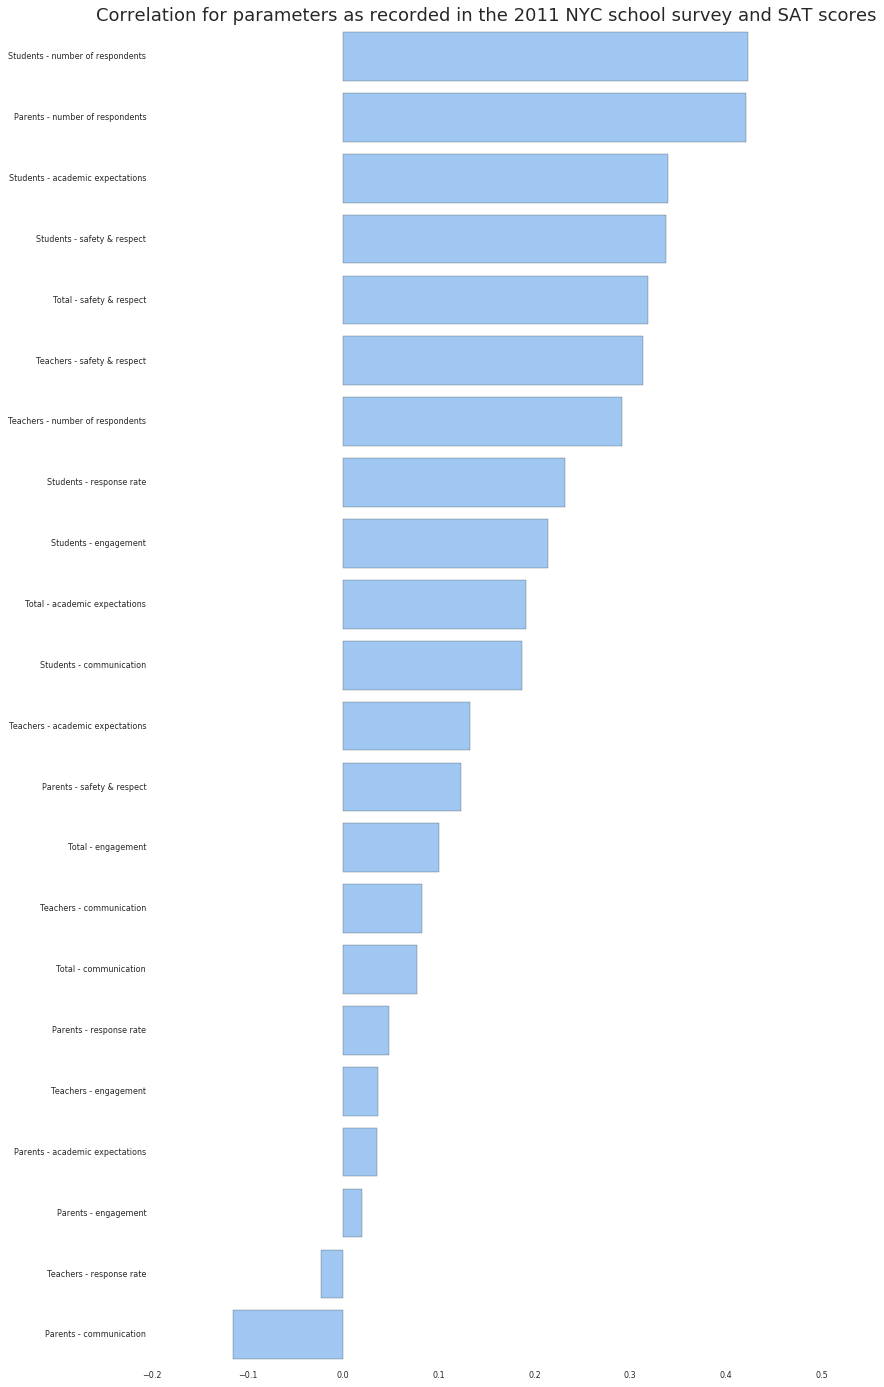

In [34]:
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

survey_fields_noDBN = [
    "rr_s", 
    "rr_t", 
    "rr_p", 
    "N_s", 
    "N_t", 
    "N_p", 
    "saf_p_11", 
    "com_p_11", 
    "eng_p_11", 
    "aca_p_11", 
    "saf_t_11", 
    "com_t_11", 
    "eng_t_11", 
    "aca_t_11", 
    "saf_s_11", 
    "com_s_11", 
    "eng_s_11", 
    "aca_s_11", 
    "saf_tot_11", 
    "com_tot_11", 
    "eng_tot_11", 
    "aca_tot_11",
]

survey_correlations = correlations[survey_fields_noDBN]

# Change column names
survey_correlations = survey_correlations.rename(index={
    "rr_s":"Students - response rate", 
    "rr_t":"Teachers - response rate", 
    "rr_p":"Parents - response rate", 
    "N_s":"Students - number of respondents", 
    "N_t":"Teachers - number of respondents", 
    "N_p":"Parents - number of respondents",
    "saf_p_11":"Parents - safety & respect", 
    "com_p_11":"Parents - communication", 
    "eng_p_11":"Parents - engagement", 
    "aca_p_11":"Parents - academic expectations",
    "saf_t_11":"Teachers - safety & respect", 
    "com_t_11":"Teachers - communication", 
    "eng_t_11":"Teachers - engagement", 
    "aca_t_11":"Teachers - academic expectations", 
    "saf_s_11":"Students - safety & respect", 
    "com_s_11":"Students - communication", 
    "eng_s_11":"Students - engagement", 
    "aca_s_11":"Students - academic expectations", 
    "saf_tot_11":"Total - safety & respect", 
    "com_tot_11":"Total - communication", 
    "eng_tot_11":"Total - engagement", 
    "aca_tot_11":"Total - academic expectations"}).sort_values(ascending=False)

 
sns.set_context('paper')
sns.set_style('white')

fig, ax = plt.subplots(figsize=(12,24))
sns.set_color_codes('pastel')
sns.barplot(y = survey_correlations.index, x=survey_correlations.values, color = 'b')
sns.set_color_codes('muted')
ax.set_title('Correlation for parameters as recorded in the 2011 NYC school survey and SAT scores', fontsize=18)
sns.despine(left = True, bottom = True)
plt.show()

## Correlation Findings

One thing to discuss before attempting to draw any cocnlusions is the value of R. How high does it need to be before one can safely say -to a certain degree- that there is indeed correlation between two phenomena? In physical experiments with accurate measurements R value will be typically above the 0.9 threshold if there is indeed correlation. However, in the social sciences and study of human behavior R values above 0.5 are rare; in this project an R value above 0.3 will be considered noteworthy. 

As such, and as per the plot above, there are three groups of data points from the 2011 NYC survey that present a reasonably high R value.

- Number of respondents (specially from students and parents)

- Academic expectations from the students

- Safety and respect



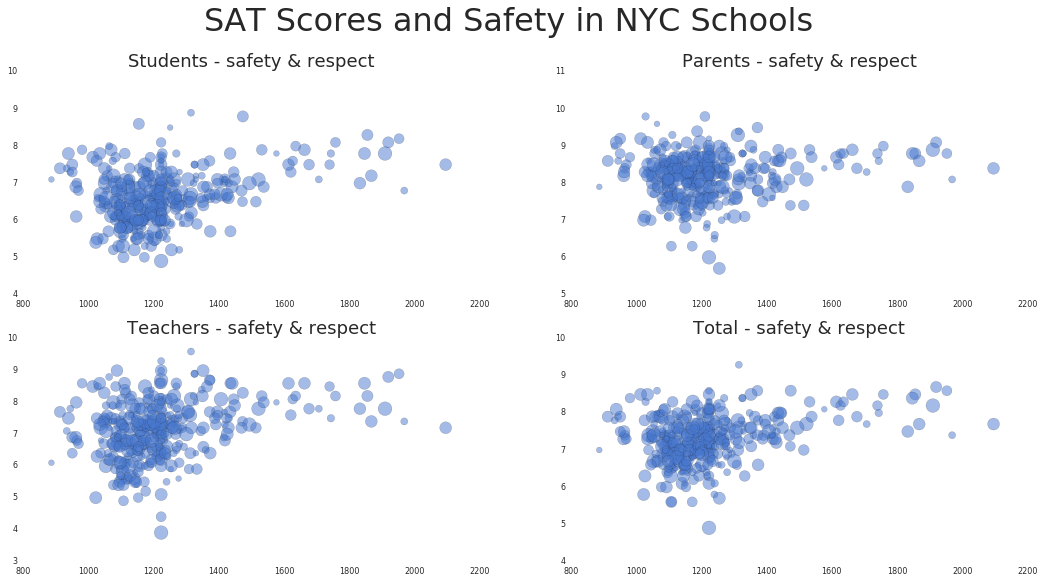

In [39]:
# Iterative variable
i = 0

#Create df only with safety and respect columns
s_list = ['saf_s_11', 'saf_t_11', 'saf_p_11', 'saf_tot_11']
safety_df = combined[s_list]

# titles for each subplot
s_titles = ['Students - safety & respect', 'Teachers - safety & respect',
           'Parents - safety & respect','Total - safety & respect']

# Create a 2x2 subplot matrix
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(18,9))
fig.suptitle('SAT Scores and Safety in NYC Schools', fontsize=32)
fig.subplots_adjust(top=0.88)
scale = 200.0 * np.random.rand(10)
# Iterate through the flattened array of the transpose of axes matrix
for ax in axes.T.flatten():
    ax.scatter(combined['sat_score'], safety_df.iloc[:,i], alpha=0.5, s=scale)
    ax.spines["right"].set_visible(False)    
    ax.spines["left"].set_visible(False)
    ax.spines["top"].set_visible(False)    
    ax.spines["bottom"].set_visible(False)
    ax.set_title(s_titles[i], fontsize=18)
    i += 1
    
plt.savefig('sat_saftey_scatter.pdf')                                                
plt.show()


## SAT Scores and Safety in NYC Schools

As can be seen in the plots above a higher degree of perceived safety and respect in schools correspond to a higher SAT score. 

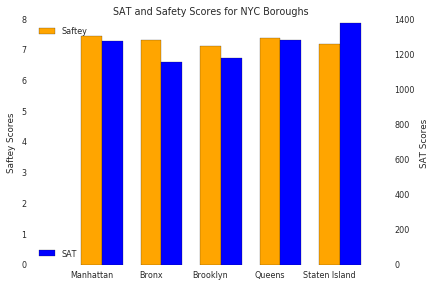

In [74]:
# Create dictionary for each boro in NYC (that apppears in the list)
boros = combined['boro'].unique()
boro_d = {}
for boro in boros:
    boro_d[boro] = combined[combined['boro']==boro]

safety_means = [boro_d[boro]['saf_tot_11'].mean() for boro in boros]
sat_means = [boro_d[boro]['sat_score'].mean() for boro in boros]
    
width = 0.35  # the width of the bars
x = np.arange(len(boros))  # the label locations

# Create a subplot matrix
fig = plt.figure() # Create matplotlib figure
ax = fig.add_subplot(111) # Create matplotlib axes
ax2 = ax.twinx() # Create another axes that shares the same x-axis as ax.

rects1 = ax.bar(x - width/2, safety_means, width, color='orange', label='Saftey')
rects2 = ax2.bar(x + width/2, sat_means, width, color='blue',  label='SAT')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Saftey Scores')
ax2.set_ylabel('SAT Scores')
ax.set_title('SAT and Safety Scores for NYC Boroughs')
ax.set_xticks(x)
ax.set_xticklabels(boros)
ax.spines["right"].set_visible(False)    
ax.spines["left"].set_visible(False)
ax.spines["top"].set_visible(False)    
ax.spines["bottom"].set_visible(False)
ax2.spines["right"].set_visible(False)    
ax2.spines["left"].set_visible(False)
ax2.spines["top"].set_visible(False)    
ax2.spines["bottom"].set_visible(False)
#ax.set_xlim(0,10)
ax.legend(loc='upper left')
ax2.legend(loc='lower left')

plt.savefig('sat_saftey_bar.pdf')                                                
plt.show()


## SAT Scores and Safety in NYC Boroughs

As can be seen in the plot above all boroughs in NYC have a similar degree of perceived safety in their schools, as they all score a mean between 7 and 7.5 on a 0-10 scale. The mean of SAT scores are not so uniformly distributed, as there is a distinc difference between e. g. Staten Island with a mean SAT score of almost 1400 and the Bronx, which has a mean of around 1100. The difference in the SAT scores must be due to some other factors.  


## Ethnicity and SAT Scores in NYC Schools


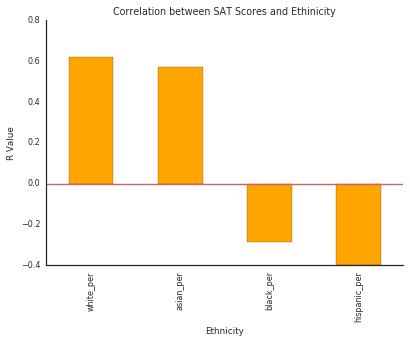

In [85]:
eth = ["white_per", "asian_per", "black_per", "hispanic_per"]
eth_correlations = correlations[eth]

# Create a subplot matrix
fig= plt.figure() # Create matplotlib figure
ax = fig.add_subplot(111) # Create matplotlib axes
# Plot bar chart
ax = eth_correlations.plot.bar(color='orange')# Horizontal line ot 0
ax.axhline(c="r")
# Set title, labels and parameters
ax.set_ylabel("R Value")
ax.set_xlabel("Ethnicity")
ax.set_title("Correlation between SAT Scores and Ethinicity")
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
ax.tick_params(bottom=True, top=False, left=False, right=False, labelbottom=True)

yada yada yada

In [79]:
print(eth_correlations.info)

AttributeError: 'Series' object has no attribute 'info'

In [27]:
s_list = ['saf_s_11', 'saf_t_11', 'saf_p_11', 'saf_tot_11']
safety_df = data['survey'][s_list]
print(combined['sat_score'], combined['saf_s_11'])

0      1122.000000
1      1172.000000
2      1149.000000
3      1207.000000
4      1621.000000
5      1856.000000
6      1182.000000
7      1194.000000
8      1156.000000
9      1111.000000
10     1293.000000
11     1269.000000
12     1051.000000
13     1148.000000
14     1200.000000
15     1127.000000
16     1176.000000
17     1435.000000
18     1223.438806
19     1223.438806
20     1223.438806
21     1419.000000
22     1522.000000
23     1577.000000
24     1677.000000
25     1419.000000
26     1758.000000
27     1614.000000
28     1170.000000
29     1306.000000
          ...     
333    1287.000000
334    1100.000000
335    1223.438806
336    1220.000000
337    1151.000000
338    1223.438806
339    1255.000000
340    1275.000000
341    1218.000000
342    1494.000000
343    1239.000000
344    1127.000000
345    1470.000000
346    1636.000000
347    1353.000000
348    1195.000000
349    1426.000000
350    1277.000000
351    1279.000000
352    1301.000000
353    1418.000000
354    1388.

In [129]:
print(survey_correlations)

Students - number of respondents    0.423463
Parents - number of respondents     0.421530
Students - academic expectations    0.339435
Students - safety & respect         0.337639
Total - safety & respect            0.318753
Teachers - safety & respect         0.313810
Teachers - number of respondents    0.291463
Students - response rate            0.232199
Students - engagement               0.213822
Total - academic expectations       0.190966
Students - communication            0.187370
Teachers - academic expectations    0.132348
Parents - safety & respect          0.122913
Total - engagement                  0.100102
Teachers - communication            0.082419
Total - communication               0.077310
Parents - response rate             0.047925
Teachers - engagement               0.036906
Parents - academic expectations     0.035155
Parents - engagement                0.020254
Teachers - response rate           -0.023386
Parents - communication            -0.115073
Name: sat_

In [ ]:
survey_fields = [
    "rr_s", 
    "rr_t", 
    "rr_p", 
    "N_s", 
    "N_t", 
    "N_p", 
    "saf_p_11", 
    "com_p_11", 
    "eng_p_11", 
    "aca_p_11", 
    "saf_t_11", 
    "com_t_11", 
    "eng_t_11", 
    "aca_t_11", 
    "saf_s_11", 
    "com_s_11", 
    "eng_s_11", 
    "aca_s_11", 
    "saf_tot_11", 
    "com_tot_11", 
    "eng_tot_11", 
    "aca_tot_11",
]